In [8]:
import pathlib
import pickle

import astropy.table as at
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

import scipy.ndimage as scn
import scipy.interpolate as sci
import scipy.optimize as sco

from jax.config import config
import jax
import jax.numpy as jnp
import jax.scipy as jsci

import jax
import jax.numpy as jnp
from jax.scipy.special import logsumexp
from jax_cosmo.scipy.interpolate import InterpolatedUnivariateSpline

import numpyro
numpyro.enable_x64()
import numpyro.distributions as dist
from jax import lax, random
from jax.scipy.stats import poisson, norm
from numpyro.distributions import TruncatedNormal
from numpyro.infer import MCMC, NUTS, Predictive

from numpyro_ext.optim import optimize

In [198]:
gd1_tbl = at.Table.read("../data/tmp/gd1-gaiadr3-blog.fits")

# We will apply one additional selection criteria to limit the number of stars we have to handle:
gd1_tbl = gd1_tbl[(gd1_tbl["gd1_phi2"] > -7) & (gd1_tbl["gd1_phi2"] < 5)]

In [199]:
gd1_data = {
    "phi1": gd1_tbl["gd1_phi1"].astype(np.float64),
    "phi2": gd1_tbl["gd1_phi2"].astype(np.float64),
}

# Model components

## Base model

In [200]:
from gd1_helpers.membership.helpers import ln_simpson

In [288]:
class ModelMixin:
    
    def ln_prob_density(self, data, return_coords=False):
        pass
    
    def ln_number_density(self, data, return_coords=False):
        pass
    
    def ln_likelihood(self, data):
        ln_density = {k: getattr(self, k)(data) for k in self.coord_names}
        ln_density = jnp.sum(jnp.array([v for v in ln_density.values()]), axis=0)
        
        ln_V = ln_simpson(
            self.splines['ln_n0'](self.integration_grid_phi1), 
            x=self.integration_grid_phi1
        )
        ln_n0 = ln_density + self.splines['ln_n0'](data['phi1'])
        return -jnp.exp(ln_V) + ln_n0.sum()

    def evaluate_on_grids(self, pars, grids=None, **kwargs):
        from gd1_helpers.membership.plot import _default_grids

        if grids is None:
            grids = {}
        for name in _default_grids:
            grids.setdefault(name, _default_grids[name])
        
        all_grids = {}
        terms = {}
        for name in self.coord_names:
            grid1, grid2 = np.meshgrid(grids["phi1"], grids[name])
            ll = getattr(self, name)({"phi1": grid1.ravel(), name: grid2.ravel(), f"{name}_err": 0.0})
            ln_dens = ll + self.splines["ln_n0"](grid1.ravel())
            terms[name] = ln_dens.reshape(grid1.shape)
            all_grids[name] = (grid1, grid2)

        return all_grids, terms
    
    def plot_projections(
        self,
        pars,
        grids=None,
        axes=None,
        label=True,
        **kwargs,
    ):
        from gd1_helpers.membership.plot import _default_labels

        grids, ln_denses = self.evaluate_on_grids(pars=pars, grids=grids, **kwargs)

        if axes is None:
            import matplotlib.pyplot as plt

            _, axes = plt.subplots(
                len(self.coord_names),
                1,
                figsize=(10, 2 + 2*len(self.coord_names)),
                sharex=True,
                sharey="row",
                constrained_layout=True,
            )
        
        if isinstance(axes, mpl.axes.Axes):
            axes = np.array([axes])
            
        for i, name in enumerate(self.coord_names):
            grid1, grid2 = grids[name]
            axes[i].pcolormesh(
                grid1, grid2, np.exp(ln_denses[name]), shading="auto", **kwargs
            )
            axes[i].set_ylim(grid2.min(), grid2.max())

            if label:
                axes[i].set_ylabel(_default_labels[name])

        axes[0].set_xlim(grid1.min(), grid1.max())

        return axes.flat[0].figure, axes

In [289]:
class SplineDensityModelBase(ModelMixin):
    coord_bounds = {}
    param_bounds = {}
    integration_grid_phi1 = None
    name = None
    knots = {}  # locations of spline knots
    spline_ks = {}  # spline order for each parameter
    
    coord_names = ['phi2', 'plx', 'pm1', 'pm2', 'rv']
    
    def __init_subclass__(cls, **kwargs):        
        # name must be specified:
        if not cls.__name__.endswith("Base") and cls.name is None:
            raise ValueError("you must specify a model component name")
        
        # Bounds for coordinates - phi1 required:
        if "phi1" not in cls.coord_bounds and "phi1" not in kwargs:
            raise ValueError(
                f"you must specify coordinate bounds for 'phi1' when defining "
                "a stream-specific subclass. Pass in class kwargs, or define "
                "the class-level `coord_bounds` dictionary directly."
            )
        
        # need to iterate over all possible coord names
        for k in ['phi1'] + cls.coord_names:
            val = kwargs.get(k, cls.coord_bounds.get(k))
            if val is not None:
                cls.coord_bounds[k] = val
                
        # Subclasses must define an integration grid in phi1 for
        # computing the effective volume in the poisson likelihood:
        if cls.integration_grid_phi1 is None:
            raise ValueError(
                "DensityModelBase subclasses must specify an integration grid used to "
                "compute the effective volume term in the poisson likelihood via "
                "integration_grid_phi1"
            )
        else:
            cls.integration_grid_phi1 = jnp.array(cls.integration_grid_phi1)
            
        # Fill out computed values and defaults for:
        # - shapes: expected parameter shapes 
        # - spline_ks: spline order for each parameter
        cls.shapes = {}
        for coord_name, bounds in cls.param_bounds.items():
            if isinstance(bounds, dict):
                cls.shapes[coord_name] = {}
                cls.spline_ks[coord_name] = {}
                for par_name in bounds:
                    cls.shapes[coord_name][par_name] = len(cls.knots[coord_name])
                    cls.spline_ks[coord_name][par_name] = cls.spline_ks[coord_name].get(
                        par_name, 3  # cubic by default
                    )
            else:
                cls.shapes[coord_name] = len(cls.knots[coord_name])
                cls.spline_ks[coord_name] = cls.spline_ks.get(
                    coord_name, 3  # cubic by default
                )
                
        # TODO: check for setup_with_params() and get_dists()
    
    @classmethod
    def clip_params(cls, pars):
        """
        Clip the input parameter dictionary so that they are within bounds
        """
        # TODO: tolerance MAGIC NUMBER 1e-2
        tol = 1e-2
        
        new_pars = {}
        for coord_name, bounds in cls.param_bounds.items():
            if isinstance(bounds, dict):
                new_pars[coord_name] = {}
                for par_name in bounds:
                    new_pars[coord_name][par_name] = jnp.clip(
                        pars[coord_name][par_name], 
                        bounds[par_name][0] + tol, 
                        bounds[par_name][1] - tol
                    )
            else:
                new_pars[coord_name] = jnp.clip(
                    pars[coord_name], 
                    bounds[0] + tol, 
                    bounds[1] - tol
                )
                    
        return new_pars
    
    @classmethod
    def _strip_model_name(cls, pars):
        """
        Remove the model component name from the parameter names.
        """
        return {k[: -(len(cls.name) + 1)]: v for k, v in pars.items()}
    
    @classmethod
    def unpack_params(cls, pars):
        pars = cls._strip_model_name(pars)
        
        upars = {}
        for k in pars.keys():
            if k == "ln_n0":
                upars['ln_n0'] = pars['ln_n0']
                continue
            
            coord_name = k.split("_")[0]
            par_name = "_".join(k.split("_")[1:])
            if coord_name not in upars:
                upars[coord_name] = {}
            upars[coord_name][par_name] = pars[k]
            
        return upars
    
    # @classmethod
    # def setup_with_params(cls, *args, **kwargs):
    #     raise NotImplementedError("This must be implemented on any subclass")
        
    def __init__(self, pars, data=None):            
        # Validate input params:
        for coord_name, bounds in self.param_bounds.items():
            if coord_name not in pars:
                raise ValueError(
                    f"Expected coordinate name '{coord_name}' in input parameters"
                )
            
            if isinstance(bounds, dict):
                for par_name in bounds:
                    if par_name not in pars[coord_name]:
                        raise ValueError(
                            f"Expected parameter name '{par_name}' for coordinate "
                            f"name '{coord_name}' in input parameters"
                        )
                    
                    pars[coord_name][par_name].shape
                    
            else:
                pars[coord_name].shape
                
        self.pars = pars
        self.setup_splines(self.pars)
        self.data = data
        
        # TODO: some inconsistency / sloppiness here, and compute_factor not implemented
        if data is not None:
            ln_V = ln_simpson(
                self.splines["ln_n0"](self.integration_grid_phi1), 
                x=self.integration_grid_phi1
            )
            ln_n0 = self.splines["ln_n0"](data['phi1'])
            factor = -jnp.exp(ln_V) + ln_n0.sum()
            numpyro.factor(
                f"obs_ln_n0_{self.name}",
                factor
            )
            
            ll_funcs = self.ln_prob_density_funcs()
            for coord_name in self.coord_names:
                numpyro.factor(
                    f"obs_{coord_name}_{self.name}", 
                    ll_funcs[coord_name](data).sum()
                )
                
            numpyro.factor(f"smooth_{self.name}", self.extra_ln_prior())
    
    def setup_splines(self, pars):
        spls = {}
        
        for coord_name, bounds in self.param_bounds.items():
            if isinstance(bounds, dict):
                spls[coord_name] = {}
                for par_name in bounds:
                    spls[coord_name][par_name] = InterpolatedUnivariateSpline(
                        self.knots[coord_name], 
                        pars[coord_name][par_name], 
                        k=self.spline_ks[coord_name][par_name]
                    )
                    
            else:    
                spls[coord_name] = InterpolatedUnivariateSpline(
                    self.knots[coord_name], 
                    pars[coord_name], 
                    k=self.spline_ks[coord_name]
                )

        self.splines = spls
        
#     def evaluate_on_grids(self, pars, grids=None, **kwargs):
#         from gd1_helpers.membership.plot import _default_grids

#         if grids is None:
#             grids = {}
#         for name in _default_grids:
#             grids.setdefault(name, _default_grids[name])

#         all_grids = {}
#         terms = {}
#         for name in self.coord_names:
#             grid1, grid2 = np.meshgrid(grids["phi1"], grids[name])
#             lls = self.ln_prob_density(
#                 {"phi1": grid1.ravel(), f"{name}_err": 0.0}, 
#                 return_terms=True
#             )

#             ln_dens = lls[name] + self.splines["ln_n0"](grid1.ravel())
#             terms[name] = ln_dens.reshape(grid1.shape)
#             all_grids[name] = (grid1, grid2)

#         return all_grids, terms
    
    
class GD1ComponentBase(SplineDensityModelBase, phi1=(-100, 20), phi2=(-7, 5)):
    integration_grid_phi1 = jnp.arange(-100, 20 + 1e-3, 0.2)
    coord_names = ['phi2']

## Background model

In [290]:
class GD1BackgroundModel(GD1ComponentBase):
    name = "background"
    
    knots = {
        "ln_n0": jnp.linspace(-110, 30, 9),
    }
    param_bounds = {
        "ln_n0": (-5, 8),
#         "phi2": {
#             "mean": (),
#             "ln_std": ()
#         }
    }
    
    @classmethod
    def setup_with_params(cls, data=None):
        pars = {}

        # ln_n0 : linear density
        pars["ln_n0"] = numpyro.sample(
            f"ln_n0_{cls.name}",
            dist.Uniform(*cls.param_bounds["ln_n0"]),
            sample_shape=(len(cls.knots["ln_n0"]),),
        )
        
        return cls(pars=pars, data=data)
    
    def phi2(self, data):
        return jnp.full(
            len(data['phi1']), 
            -jnp.log(self.coord_bounds['phi2'][1] - self.coord_bounds['phi2'][0])
        )
        # return jnp.sum(jnp.array([v for v in lls.values()]), axis=0)
    
    def extra_ln_prior(self):
        lp = 0.

        # Smoothness priors
        smooth = {
            "ln_n0": 1. / 30.
        }
        for coord_name, stds in smooth.items():
            knots = self.knots[coord_name]
            
            if isinstance(stds, dict):
                for par_name, std in stds.items():
                    deriv = self.splines[coord_name][par_name].derivative(knots)
                    lp = lp + dist.Normal(deriv[:-1], std).log_prob(deriv[1:]).sum()
            else:
                deriv = self.splines[coord_name].derivative(knots)
                lp = lp + dist.Normal(deriv[:-1], stds).log_prob(deriv[1:]).sum()

        return lp

In [291]:
prior = Predictive(GD1BackgroundModel.setup_with_params, num_samples=2)
prior_samples = prior(jax.random.PRNGKey(0))
prior_samples

{'ln_n0_background': DeviceArray([[ 6.63902276, -2.18592574,  5.52180496,  2.70726474,
               -0.89758006, -1.52539024, -1.40605561, -3.40867246,
                1.20352626],
              [ 1.49230793,  1.48697108, -1.83995948,  7.16183821,
                6.04476646, -1.45052859, -4.16320332,  1.89826236,
                2.63761386]], dtype=float64)}

In [292]:
background_prior_pars = GD1BackgroundModel.unpack_params({k: v[0] for k, v in prior_samples.items()})
background = GD1BackgroundModel(background_prior_pars)
background.ln_likelihood(gd1_data)

DeviceArray(-12859.33388903, dtype=float64)

In [295]:
background.phi2(gd1_data)

DeviceArray([-2.48490665, -2.48490665, -2.48490665, ..., -2.48490665,
             -2.48490665, -2.48490665], dtype=float64, weak_type=True)

(<Figure size 1000x400 with 1 Axes>,
 array([<AxesSubplot: ylabel='$\\phi_2$'>], dtype=object))

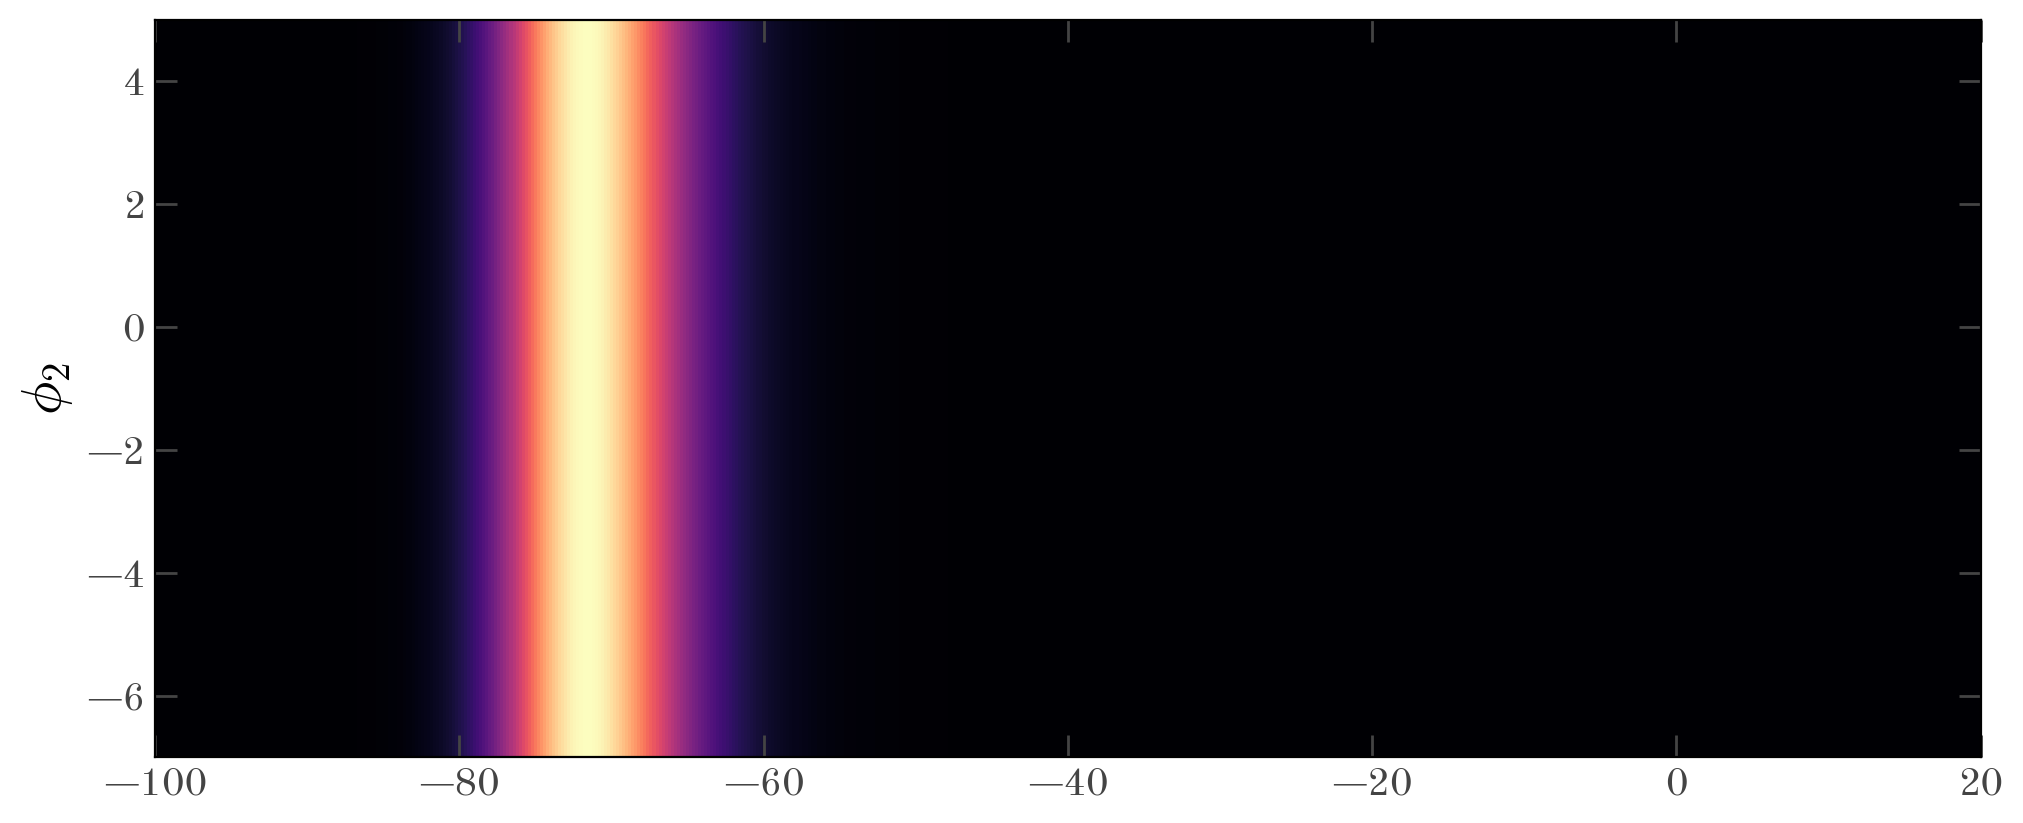

In [296]:
background.plot_projections(background_prior_pars)

## Stream model

In [297]:
from gd1_helpers.membership.helpers import ln_truncated_normal, ln_normal

In [298]:
class GD1StreamModel(GD1ComponentBase):
    name = "stream"
    
    _step_n0 = 3.  # deg
    _step_phi2 = 5.  # deg
    knots = {
        "ln_n0": jnp.arange(-100 - 2 * _step_n0, 20 + 2 * _step_n0 + 1e-3, _step_n0),
        "phi2": jnp.arange(-100 - 2 * _step_phi2, 20 + 2 * _step_phi2 + 1e-3, _step_phi2), 
    }
    
    param_bounds = {
        "ln_n0": (-5, 8),
        "phi2": {
            "mean": GD1ComponentBase.coord_bounds['phi2'],
            "ln_std": (-1, 0.5)
        }
    }
    
    @classmethod
    def setup_with_params(cls, data=None):
        pars = {}

        # ln_n0 : linear density
        pars["ln_n0"] = numpyro.sample(
            f"ln_n0_{cls.name}",
            dist.Uniform(*cls.param_bounds["ln_n0"]),
            sample_shape=(len(cls.knots["ln_n0"]),),
        )
        
        # Other coordinates:
        for coord_name in cls.coord_names:
            pars[coord_name] = {}
            for par_name in ["mean", "ln_std"]:
                pars[coord_name][par_name] = numpyro.sample(
                    f"{coord_name}_{par_name}_{cls.name}",
                    dist.Uniform(*cls.param_bounds[coord_name][par_name]),
                    sample_shape=(len(cls.knots[coord_name]),),
                )
        
        return cls(pars=pars, data=data)
    
    def phi2(self, data):
        return ln_truncated_normal(
            data['phi2'],
            mu=self.splines["phi2"]["mean"](data['phi1']),
            var=jnp.exp(2 * self.splines["phi2"]["ln_std"](data['phi1'])),
            lower=self.coord_bounds['phi2'][0],
            upper=self.coord_bounds['phi2'][1],
        )
    
    def extra_ln_prior(self):
        lp = 0.

        # Smoothness priors
        smooth = {
            "ln_n0": 1. / 30.,
            "phi2": {
                "mean": 1. / 10.,
                "ln_std": 0.5 / 10.,
            },
#             "pm1": {
#                 "mean": 1 / 10.,
#                 "ln_std": 0.5 / 10.
#             },
#             "pm2": {
#                 "mean": 1 / 10.,
#                 "ln_std": 0.5 / 10.
#             }
        }
        for coord_name, stds in smooth.items():
            knots = self.knots[coord_name]
            
            if isinstance(stds, dict):
                for par_name, std in stds.items():
                    deriv = self.splines[coord_name][par_name].derivative(knots)
                    lp = lp + dist.Normal(deriv[:-1], std).log_prob(deriv[1:]).sum()
            else:
                deriv = self.splines[coord_name].derivative(knots)
                lp = lp + dist.Normal(deriv[:-1], stds).log_prob(deriv[1:]).sum()

        return lp

In [299]:
prior = Predictive(GD1StreamModel.setup_with_params, num_samples=2)
prior_samples = prior(jax.random.PRNGKey(0))
prior_samples

{'ln_n0_stream': DeviceArray([[ 3.34913081,  7.87044079, -4.32870569,  7.33344109,
               -2.17099113,  4.67912201,  0.52240758, -4.33200413,
                2.86674063,  1.97368577,  1.49886087, -1.12819042,
               -2.72659816, -2.3871381 ,  3.73297284, -3.16822971,
                1.95919949, -0.15774433,  5.51616278,  7.56018283,
                6.66134685, -4.1425858 ,  0.279566  , -4.43198091,
               -2.09419931,  6.57714603,  1.39705076,  6.51166235,
                0.57531526, -0.64705133, -0.92772598, -2.46299772,
               -3.06964229,  6.17079545,  5.81594425, -0.38600539,
                2.62661897, -3.43341065,  1.82833489, -1.60492554,
                6.78672098,  3.561287  , -1.73259119,  0.82610715,
                6.28741055],
              [-0.47547338, -2.93457906, -0.08993712,  7.32285273,
                0.62338285,  0.28235615, -3.6434538 ,  3.44124539,
               -0.17364385, -0.3386845 , -2.42346409,  6.00567531,
                0

In [300]:
stream_prior_pars = GD1StreamModel.unpack_params({k: v[1] for k, v in prior_samples.items()})
stream = GD1StreamModel(stream_prior_pars)
stream.ln_likelihood(gd1_data)

DeviceArray(-70729.14808115, dtype=float64)

(<Figure size 1000x400 with 1 Axes>,
 array([<AxesSubplot: ylabel='$\\phi_2$'>], dtype=object))

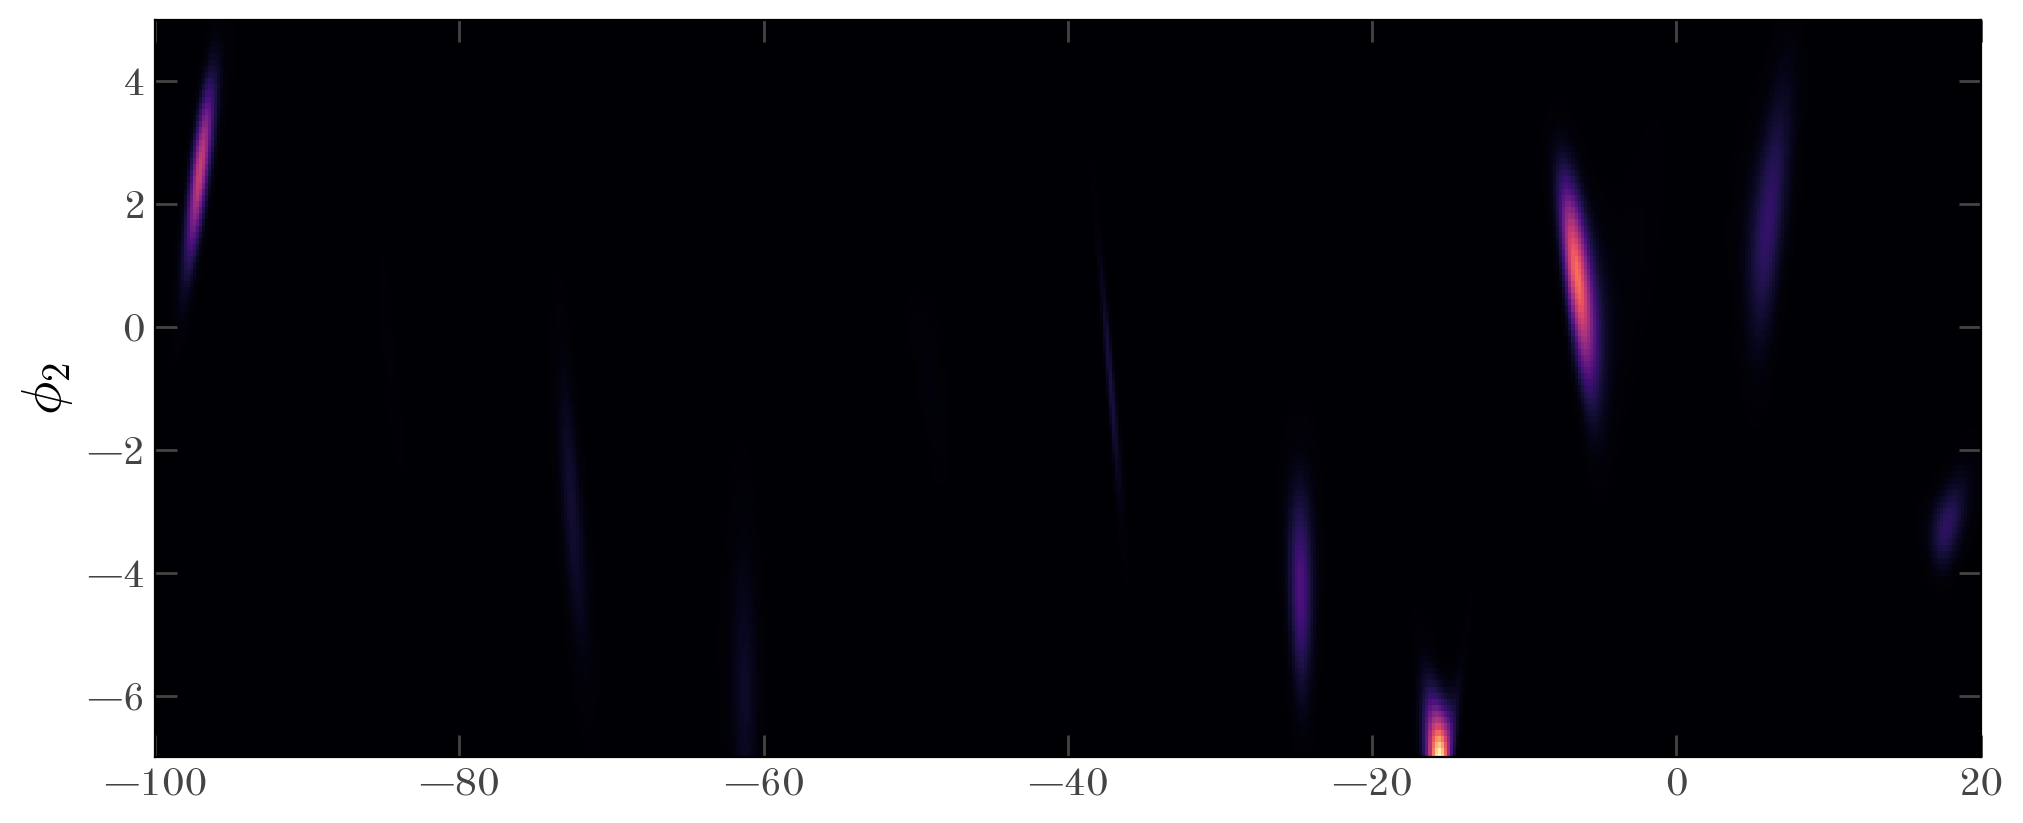

In [303]:
stream.plot_projections(stream_prior_pars)

## Mixture model

In [320]:
class SplineDensityMixtureModel(ModelMixin):
   
    def __init__(self, components, data=None, integration_grid_phi1=None):
        self.coord_names = None
        
        # TODO: validate that at least 1 compinent here
        self.components = components
        
        # Find the integration grid with the smallest step size:
        if integration_grid_phi1 is None:
            integration_grid_phi1 = components[0].integration_grid_phi1
            
        for component in self.components:
            if self.coord_names is None:
                self.coord_names = tuple(component.coord_names)
            else:
                if self.coord_names != tuple(component.coord_names):
                    raise ValueError("TODO")

        self.integration_grid_phi1 = integration_grid_phi1
        
        # TODO: some inconsistency / sloppiness here, and compute_factor not implemented
        self.data = data
        if data is not None:
            # TODO: need to compute ln_n0 here
            
            ln_V_terms = {
                c.name: c.splines['ln_n0'](self.integration_grid_phi1) 
                for c in self.components
            }
            ln_V = ln_simpson(
                logsumexp(jnp.array([v for v in ln_V_terms.values()]), axis=0), 
                x=self.integration_grid_phi1
            )
            factor = -jnp.exp(ln_V) + ln_n0.sum()
            
            numpyro.factor(
                f"obs_ln_n0",
                factor
            )
            for coord_name in self.coord_names:
                numpyro.sample(
                    f"obs_{coord_name}", 
                    dists[coord_name], 
                    obs=data[coord_name]
                )
            
            # for c in self.components:
            #     numpyro.factor(f"smooth_{c.name}", c.extra_ln_prior())
    
    @classmethod
    def setup_with_params(cls, Components, data=None):
        components = []  # instances
        for Component in Components:
            components.append(Component.setup_with_params(data=None))
        return cls(components, data=data)
    
    # TODO: could implement this in a generic getattr() if key in self.coord_names?
    def phi2(self, data):        
        lls = []
        ln_n0s = []
        for component in self.components:
            lls.append(component.phi2(data))
            ln_n0s.append(component.splines['ln_n0'](data['phi1']))
            
        ln_n0 = logsumexp(jnp.array(ln_n0s), axis=0)
        ln_ws = jnp.array([l - ln_n0 for l in ln_n0s])
        ll = logsumexp(jnp.array([ll + lw for ll, lw in zip(ln_n0s, ln_ws)]), axis=0)
        return ll
    
    def ln_likelihood(self, data):
        ln_density = self.ln_prob_density(data)
        
        # TODO: ln_n0
        ln_V = ln_simpson(
            self.splines['ln_n0'](self.integration_grid_phi1), 
            x=self.integration_grid_phi1
        )
        ln_n0 = ln_density + self.splines['ln_n0'](data['phi1'])
        return -jnp.exp(ln_V) + ln_n0.sum()
    
    def evaluate_on_grids(self, pars, grids=None, **kwargs):
        from gd1_helpers.membership.plot import _default_grids

        if grids is None:
            grids = {}
        for name in _default_grids:
            grids.setdefault(name, _default_grids[name])
        
        all_grids = {}
        terms = {}
        for name in self.coord_names:
            grid1, grid2 = np.meshgrid(grids["phi1"], grids[name])
            ln_dens = getattr(self, name)({"phi1": grid1.ravel(), name: grid2.ravel(), f"{name}_err": 0.0})
            terms[name] = ln_dens.reshape(grid1.shape)
            all_grids[name] = (grid1, grid2)

        return all_grids, terms
    
    @classmethod
    def unpack_params(cls, pars, Components):
        pars_unpacked = {}
        for C in Components:
            pars_unpacked[C.name] = {}
            
        for par_name, par in pars.items():
            for C in Components:
                if par_name.endswith(C.name):
                    pars_unpacked[C.name][par_name] = par
                    break
        for C in Components:
            pars_unpacked[C.name] = C.unpack_params(pars_unpacked[C.name])
        return pars_unpacked

In [321]:
tmp_mixture_model = SplineDensityMixtureModel([stream, background])
pars = {
    'background': background_prior_pars,
    'stream': stream_prior_pars
}
grids, vals = tmp_mixture_model.evaluate_on_grids(pars)

TypeError: reshape total size must be unchanged, got new_sizes (121, 601) for shape (2, 72721).

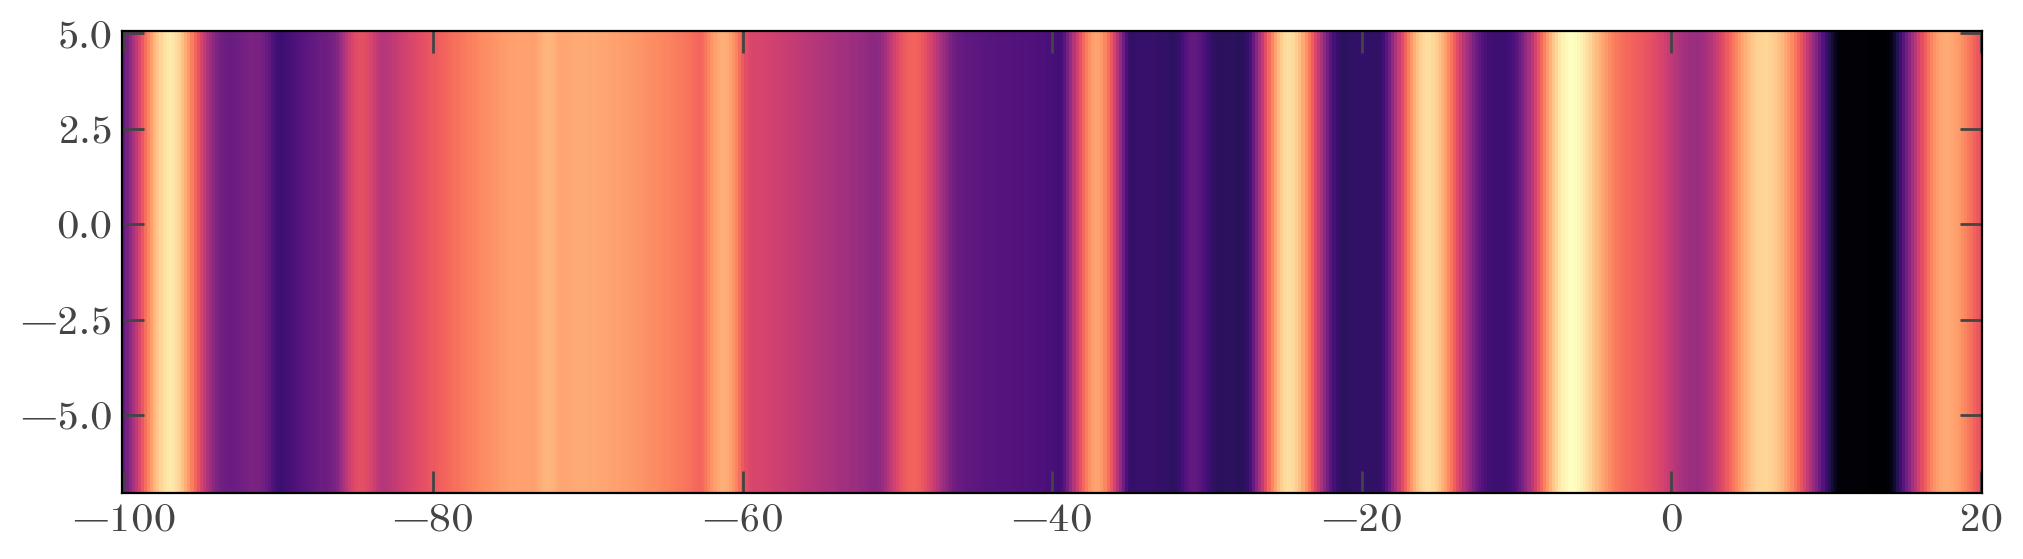

In [319]:
fig, ax = plt.subplots(figsize=(12, 3))
ax.pcolormesh(
    grids['phi2'][0],
    grids['phi2'][1],
    vals['phi2'],
    shading='auto'
)

# Initialization:

Text(0.5, 0, '$\\phi_1$')

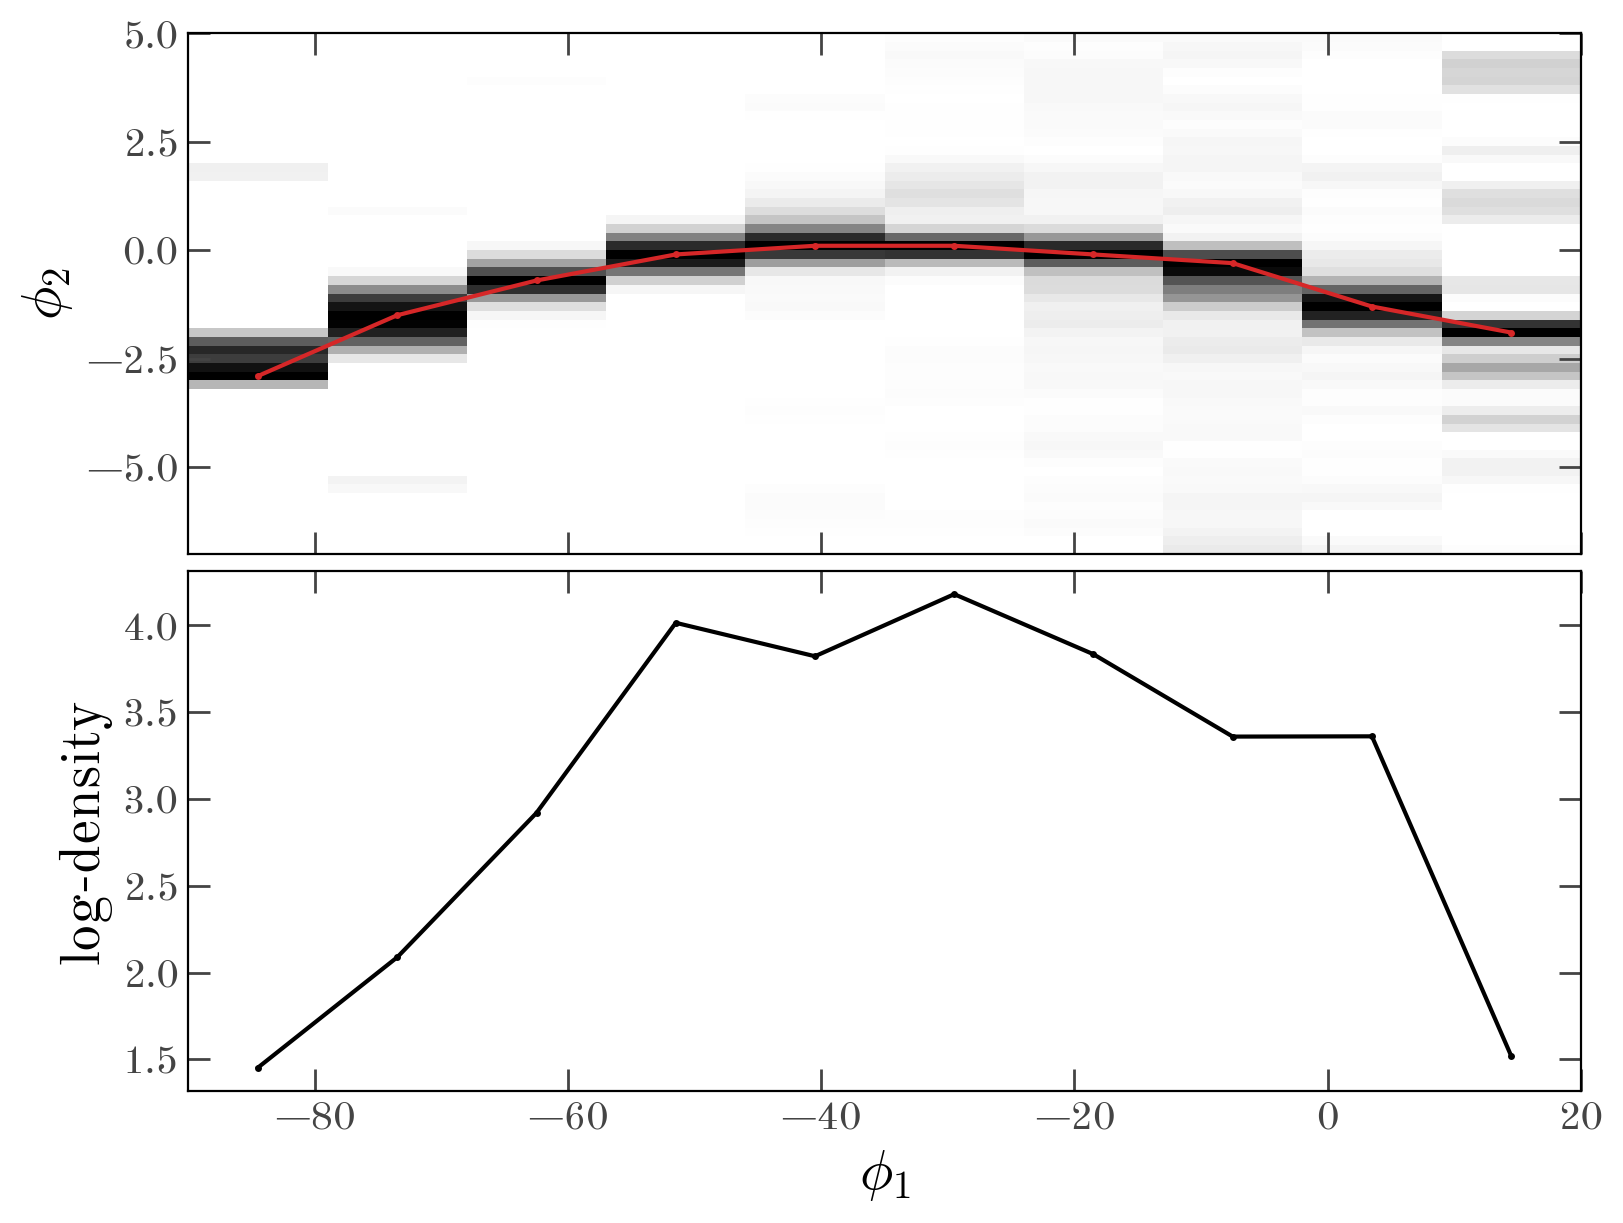

In [38]:
from scipy.ndimage import gaussian_filter1d

H, xe, ye = np.histogram2d(
    gd1_tbl["gd1_phi1"],
    gd1_tbl["gd1_phi2"],
    bins=(np.linspace(-90, 20 + 1e-3, 11), np.arange(-7, 5 + 1e-3, 0.2)),
)
xc = 0.5 * (xe[:-1] + xe[1:])
yc = 0.5 * (ye[:-1] + ye[1:])

H = gaussian_filter1d(H, sigma=1)
H -= np.mean(H[:, (yc < -5) | (yc > 3)])

H /= (xe[1] - xe[0]) / 12
H_density = H.copy()

peak_idx = H.argmax(axis=1)
H /= H[np.arange(H.shape[0]), peak_idx][:, None]
H_ln_density = np.log(H_density[np.arange(H.shape[0]), peak_idx])


fig, axes = plt.subplots(2, 1, figsize=(8, 6), sharex=True, constrained_layout=True)
cs = axes[0].pcolormesh(xe, ye, H.T, vmin=0, vmax=1, cmap="Greys")
axes[0].plot(xc, yc[peak_idx], color="tab:red")
axes[0].set_ylabel(r"$\phi_2$")
axes[1].plot(xc, H_ln_density)
axes[1].set_ylabel(r"log-density")
axes[1].set_xlabel(r"$\phi_1$")

In [39]:
init_ln_n0 = sci.InterpolatedUnivariateSpline(xc, H_ln_density)(GD1StreamModel.knots['ln_n0'])
init_mean_phi2 = sci.InterpolatedUnivariateSpline(xc, yc[peak_idx])(GD1StreamModel.knots['phi2'])

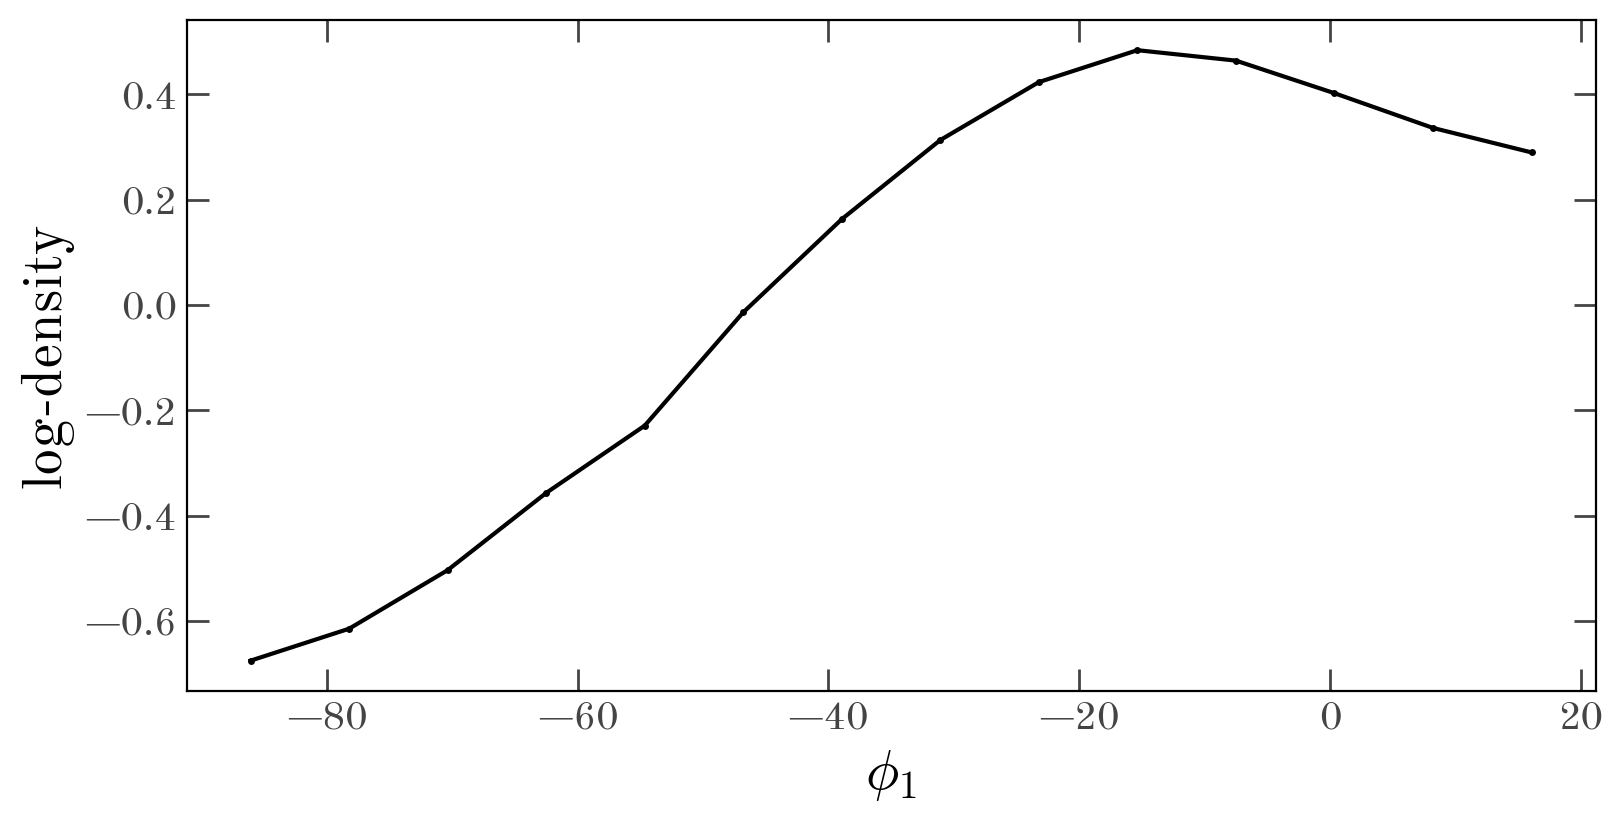

In [40]:
_mask = (gd1_tbl["gd1_phi2"] > 3) | (gd1_tbl["gd1_phi2"] < -5)
H, xe = np.histogram(gd1_tbl["gd1_phi1"][_mask], bins=np.linspace(-90, 20 + 1e-3, 15))
xc = 0.5 * (xe[:-1] + xe[1:])

dx = xe[1] - xe[0]
H = np.log(gaussian_filter1d(H, sigma=2) / dx / 4)

fig, ax = plt.subplots(figsize=(8, 4), constrained_layout=True)
ax.plot(xc, H)
ax.set_ylabel(r"log-density")
ax.set_xlabel(r"$\phi_1$")

init_ln_n0_bkg = sci.InterpolatedUnivariateSpline(xc, H)(GD1StreamModel.knots['ln_n0'])

In [41]:
init_pars = {
    "stream": {
        "ln_n0": init_ln_n0,
        "phi2": {
            "mean": init_mean_phi2,
            "ln_std": np.full_like(init_mean_phi2, -0.75)
        }
    },
    "background": {
        "ln_n0": init_ln_n0_bkg,
    }
}
# init_pars["stream"] = GD1StreamModel.clip_params(init_pars["stream"])
init_pars["background"] = GD1BackgroundModel.clip_params(init_pars["background"])

### Test optimize: Background only

In [49]:
background_optimize = optimize(
    GD1BackgroundModel.setup_with_params, 
    start=init_pars["background"],
    return_info=True
)
background_opt_pars, info = background_optimize(
    jax.random.PRNGKey(0), 
    data=gd1_data
)

(<Figure size 1200x600 with 3 Axes>,
 array([<AxesSubplot: ylabel='$\\phi_2$'>], dtype=object))

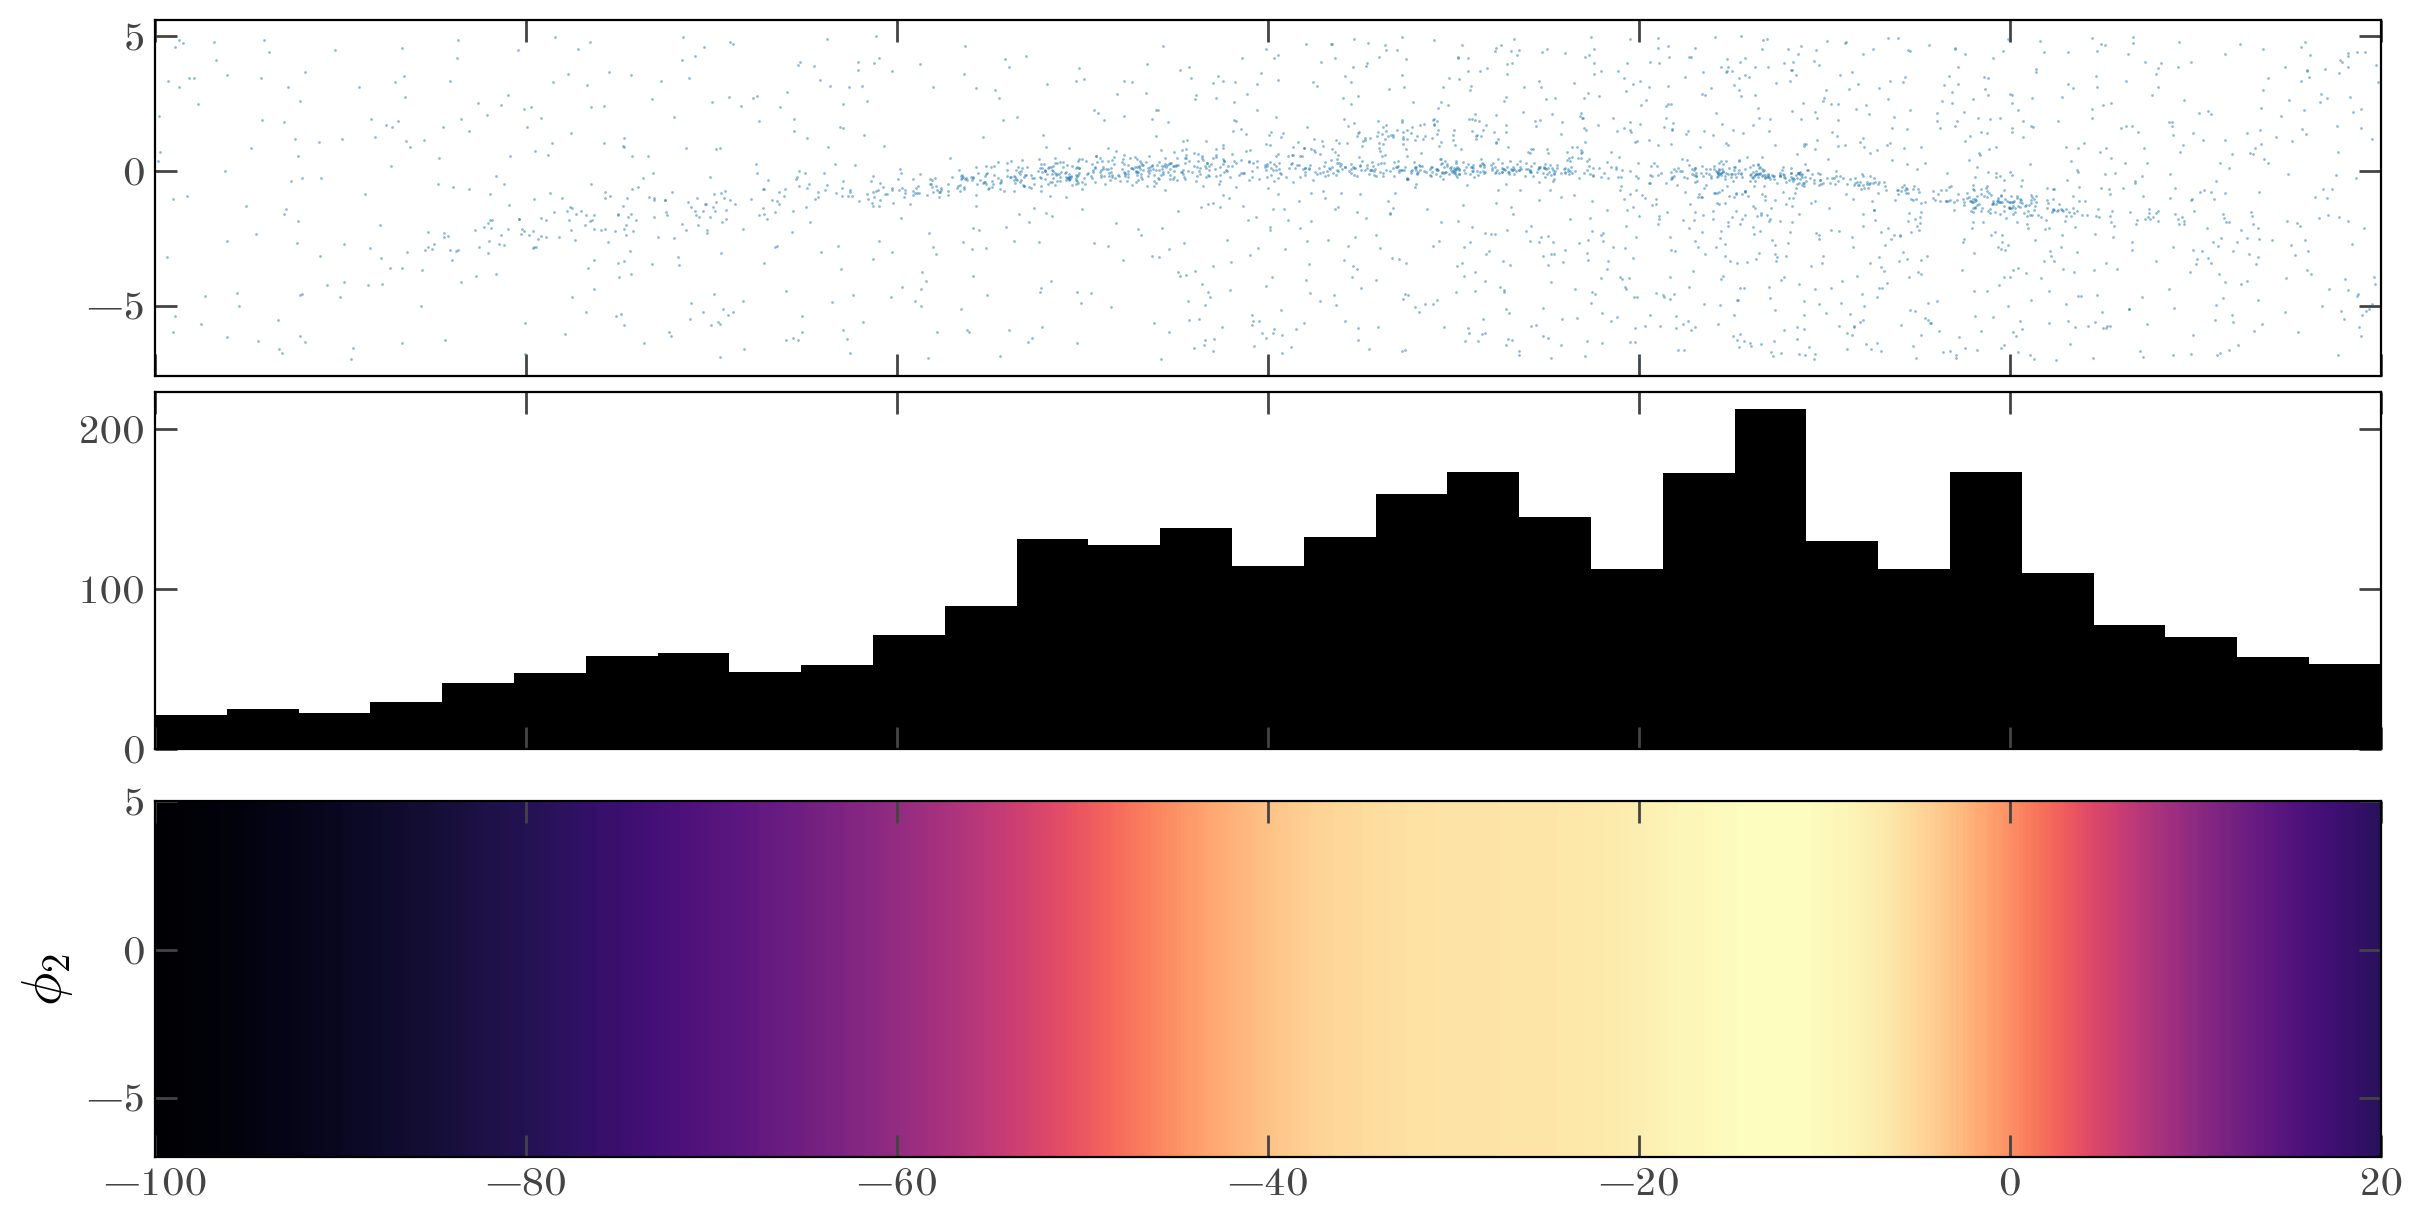

In [60]:
tmp = GD1BackgroundModel(GD1BackgroundModel.unpack_params(background_opt_pars))

fig, axes = plt.subplots(3, 1, figsize=(12, 6), sharex=True,
                         constrained_layout=True)
axes[0].plot(gd1_data['phi1'], gd1_data['phi2'], ls='none', color='tab:blue', ms=2, alpha=0.5)
axes[1].hist(gd1_data['phi1'], bins=np.linspace(-100, 20, 32))
tmp.plot_projections(tmp, axes=axes[2:])

### Optimize mixture model

In [70]:
joint_optimize = optimize(
    SplineDensityMixtureModel.setup_with_params, 
    start=init_pars,
    return_info=True
)
# Components = [GD1StreamModel, GD1BackgroundModel]
Components = [GD1BackgroundModel]
opt_pars, info = joint_optimize(
    jax.random.PRNGKey(0), 
    Components=Components, 
    data=gd1_data
)

In [71]:
info

ScipyMinimizeInfo(fun_val=DeviceArray(-400.5376382, dtype=float64, weak_type=True), success=False, status=2, iter_num=234)

In [67]:
# opt_pars
opt_pars_unpacked = SplineDensityMixtureModel.unpack_params(opt_pars, Components)
opt_pars_unpacked

{'background': {'ln_n0': DeviceArray([1.08057288, 1.89779634, 2.49960099, 3.07030964, 3.60511814,
               3.64633759, 3.67424244, 2.77257265, 3.06684276],            dtype=float64)}}

(<Figure size 1200x600 with 3 Axes>,
 array([<AxesSubplot: ylabel='$\\phi_2$'>], dtype=object))

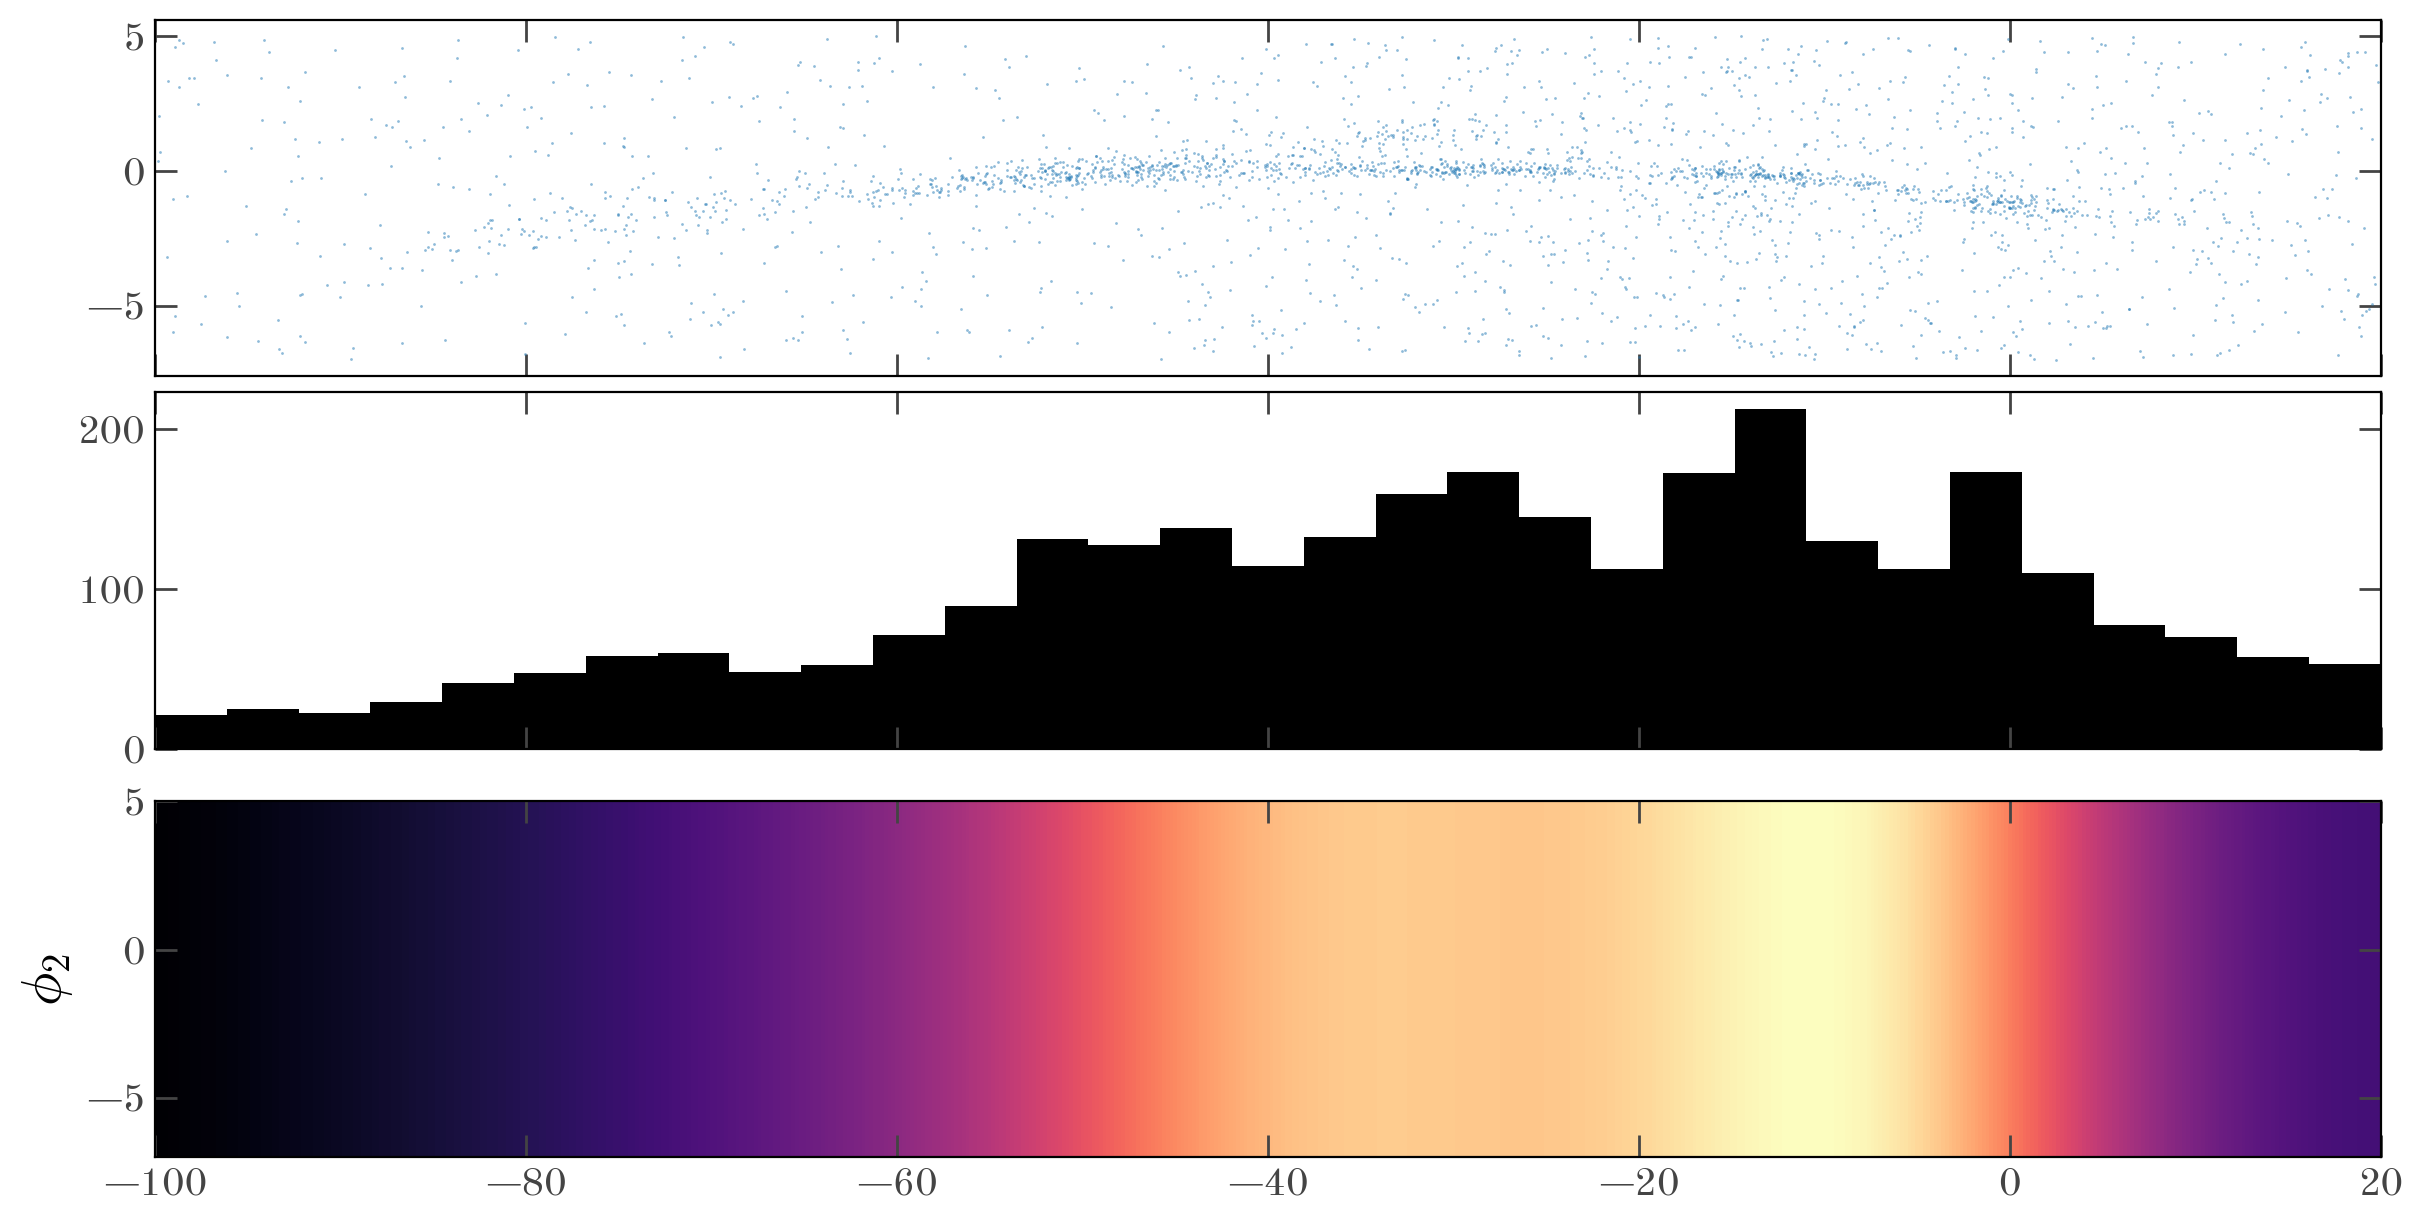

In [68]:
tmp = GD1BackgroundModel(opt_pars_unpacked["background"])

fig, axes = plt.subplots(3, 1, figsize=(12, 6), sharex=True,
                         constrained_layout=True)
axes[0].plot(gd1_data['phi1'], gd1_data['phi2'], ls='none', color='tab:blue', ms=2, alpha=0.5)
axes[1].hist(gd1_data['phi1'], bins=np.linspace(-100, 20, 32))
tmp.plot_projections(tmp, axes=axes[2:])